In [1]:
# --- Coral mask builder: bleached ∪ non-bleached -> coral ---
from pathlib import Path
import numpy as np
import imageio.v2 as iio
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

# ========== Paths (notebook is next to bleaching_data_RS) ==========
base_dir = Path("bleaching_data_RS")
images_dir = base_dir / "images"
bleached_dir = base_dir / "masks_bleached"
healthy_dir  = base_dir / "masks_non_bleached"
out_dir      = base_dir / "masks_coral"
out_dir.mkdir(parents=True, exist_ok=True)

assert images_dir.is_dir(), f"Missing folder: {images_dir}"
assert bleached_dir.is_dir(), f"Missing folder: {bleached_dir}"
assert healthy_dir.is_dir(),  f"Missing folder: {healthy_dir}"

# ========== Helpers ==========
def read_mask_bool(path, target_hw=None):
    """Read a single-channel PNG mask as boolean (>0). Optionally resize to target (H,W) using nearest neighbor."""
    arr = iio.imread(path)
    if arr.ndim == 3:   # handle accidental RGB masks
        arr = arr[...,0]
    if target_hw is not None and (arr.shape[0], arr.shape[1]) != target_hw:
        # Nearest-neighbor resize without OpenCV: use numpy indexing
        # Build index grids
        Ht, Wt = target_hw
        Hs, Ws = arr.shape[:2]
        ys = (np.linspace(0, Hs-1, Ht)).round().astype(int)
        xs = (np.linspace(0, Ws-1, Wt)).round().astype(int)
        arr = arr[ys[:,None], xs[None,:]]
    return arr > 0

def overlay(img, mask, alpha=0.4):
    """Simple overlay (mask in red). img expected uint8 RGB, mask boolean HxW."""
    viz = img.copy().astype(np.float32)
    if viz.ndim == 2:  # grayscale safety
        viz = np.repeat(viz[...,None], 3, axis=2)
    r,g,b = viz[...,0], viz[...,1], viz[...,2]
    r = np.where(mask, 255*alpha + r*(1-alpha), r)
    g = np.where(mask, g*(1-alpha), g)
    b = np.where(mask, b*(1-alpha), b)
    out = np.stack([r,g,b], axis=-1).clip(0,255).astype(np.uint8)
    return out

# ========== Pass 1: build coral masks & manifest ==========
rows = []
created, skipped, no_masks, errors = 0, 0, 0, 0

image_paths = sorted(images_dir.glob("*.jpg"))
if not image_paths:
    warnings.warn("No .jpg images found in images/.")
    
for img_path in image_paths:
    stem = img_path.stem  # base name without extension
    mb_path = bleached_dir / f"{stem}_bleached.png"
    mh_path = healthy_dir  / f"{stem}_non_bleached.png"
    out_path = out_dir / f"{stem}_coral.png"

    try:
        img = iio.imread(img_path)
        H, W = img.shape[:2]

        has_b = mb_path.exists()
        has_h = mh_path.exists()

        if not has_b and not has_h:
            no_masks += 1
            rows.append({
                "image": str(img_path),
                "mask_bleached": str(mb_path) if has_b else "",
                "mask_non_bleached": str(mh_path) if has_h else "",
                "mask_coral": "",
                "status": "no_masks_found",
                "coral_pixels": 0,
                "height": H, "width": W
            })
            continue

        # Read available masks and union -> coral
        M_bleached = read_mask_bool(mb_path, (H,W)) if has_b else np.zeros((H,W), dtype=bool)
        M_healthy  = read_mask_bool(mh_path, (H,W)) if has_h else np.zeros((H,W), dtype=bool)
        M_coral = (M_bleached | M_healthy)

        # Save as 0/255 PNG
        iio.imwrite(out_path, (M_coral.astype(np.uint8) * 255))

        created += 1
        rows.append({
            "image": str(img_path),
            "mask_bleached": str(mb_path) if has_b else "",
            "mask_non_bleached": str(mh_path) if has_h else "",
            "mask_coral": str(out_path),
            "status": "created",
            "coral_pixels": int(M_coral.sum()),
            "height": H, "width": W
        })

    except Exception as e:
        errors += 1
        rows.append({
            "image": str(img_path),
            "mask_bleached": str(mb_path),
            "mask_non_bleached": str(mh_path),
            "mask_coral": "",
            "status": f"error: {type(e).__name__}: {e}",
            "coral_pixels": 0
        })

manifest = pd.DataFrame(rows)
manifest_path = base_dir / "coral_manifest.csv"
manifest.to_csv(manifest_path, index=False)

# ========== Summary ==========
total = len(image_paths)
print(f"Total images:      {total}")
print(f"Created coral:     {created}")
print(f"No matching masks: {no_masks}")
print(f"Errors:            {errors}")
print(f"Manifest saved to: {manifest_path}")
print(f"Coral masks in:    {out_dir}")

KeyboardInterrupt: 

Locations found:           8
Total images scanned:      3311
Coral masks created:       3311
Images with no mask found: 0
Errors:                    0
Manifest saved to:         benthic_data\reef_support\coral_manifest_reef_support.csv

Coral pixel stats (created):
count    3.311000e+03
mean     1.082576e+06
std      1.602747e+06
min      0.000000e+00
25%      9.728100e+04
50%      3.848750e+05
75%      1.233744e+06
max      1.036421e+07
Name: coral_pixels, dtype: float64


C:\Users\timow\AppData\Local\Temp\ipykernel_58736\3912450510.py:115: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = created_rows.groupby("location", group_keys=False).apply(lambda g: g.sample(min(1, len(g)), random_state=0)).sample(n_show, random_state=1) \


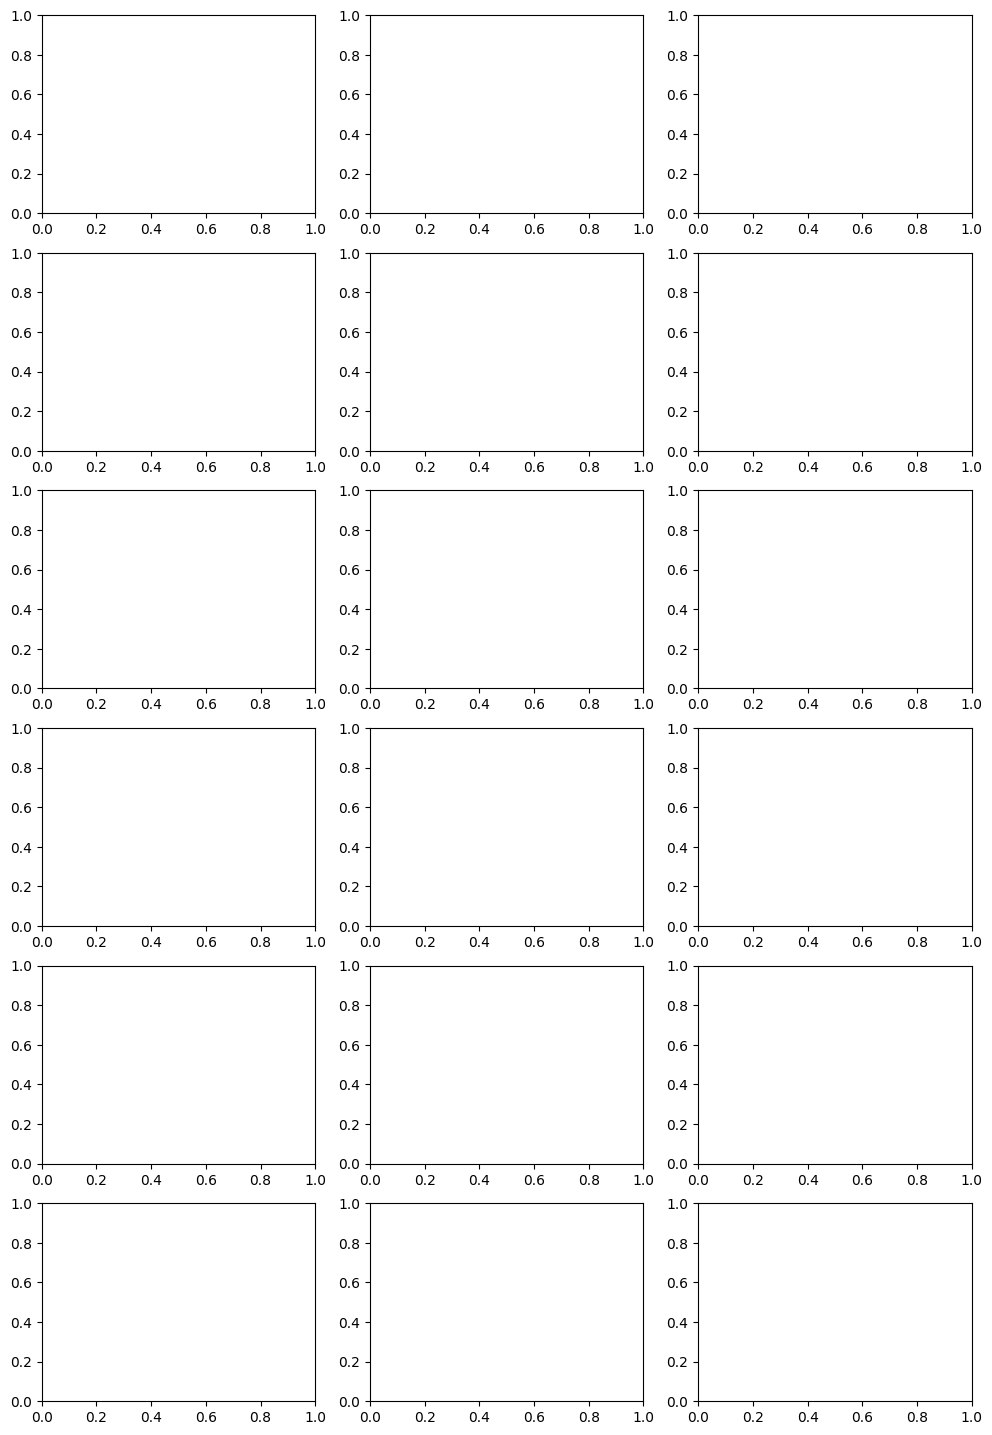

In [ ]:
# --- Build coral masks for benthic_data/reef_support/ ---
from pathlib import Path
import numpy as np
import imageio.v2 as iio
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

root = Path("benthic_data") / "reef_support"
assert root.is_dir(), f"Missing folder: {root}"

def nn_resize_mask(arr, target_hw):
    """Nearest-neighbor resize without OpenCV; arr is 2D."""
    Ht, Wt = target_hw
    Hs, Ws = arr.shape[:2]
    if (Hs, Ws) == (Ht, Wt):
        return arr
    ys = (np.linspace(0, Hs-1, Ht)).round().astype(int)
    xs = (np.linspace(0, Ws-1, Wt)).round().astype(int)
    return arr[ys[:, None], xs[None, :]]

def read_mask_bool(path, target_hw=None):
    """Read PNG mask and convert to boolean (>0)."""
    arr = iio.imread(path)
    if arr.ndim == 3:
        arr = arr[..., 0]
    if target_hw is not None:
        arr = nn_resize_mask(arr, target_hw)
    return arr > 0

rows = []
locations = sorted([p for p in root.iterdir() if p.is_dir()])
if not locations:
    warnings.warn("No location folders found under reef_support/")

total_imgs = total_created = total_missing = total_errors = 0

for loc in locations:
    img_dir = loc / "images"
    stitched_dir = loc / "masks_stitched"
    out_dir = loc / "masks_coral"
    out_dir.mkdir(parents=True, exist_ok=True)

    if not img_dir.is_dir() or not stitched_dir.is_dir():
        warnings.warn(f"Skipping {loc.name}: missing images/ or masks_stitched/")
        continue

    for img_path in sorted(img_dir.glob("*.JPG")):
        total_imgs += 1
        stem = img_path.stem                       # base name without extension
        mask_path = stitched_dir / f"{stem}_mask.png"
        out_path  = out_dir / f"{stem}_coral.png"

        try:
            img = iio.imread(img_path)
            H, W = img.shape[:2]
            if not mask_path.exists():
                total_missing += 1
                rows.append({
                    "location": loc.name,
                    "image": str(img_path),
                    "mask_stitched": str(mask_path),
                    "mask_coral": "",
                    "status": "no_mask_found",
                    "coral_pixels": 0,
                    "height": H, "width": W
                })
                continue

            M = read_mask_bool(mask_path, (H, W))
            iio.imwrite(out_path, (M.astype(np.uint8) * 255))
            total_created += 1
            rows.append({
                "location": loc.name,
                "image": str(img_path),
                "mask_stitched": str(mask_path),
                "mask_coral": str(out_path),
                "status": "created",
                "coral_pixels": int(M.sum()),
                "height": H, "width": W
            })

        except Exception as e:
            total_errors += 1
            rows.append({
                "location": loc.name,
                "image": str(img_path),
                "mask_stitched": str(mask_path),
                "mask_coral": "",
                "status": f"error: {type(e).__name__}: {e}",
                "coral_pixels": 0
            })

manifest = pd.DataFrame(rows)
manifest_path = root / "coral_manifest_reef_support.csv"
manifest.to_csv(manifest_path, index=False)

print(f"Locations found:           {len(locations)}")
print(f"Total images scanned:      {total_imgs}")
print(f"Coral masks created:       {total_created}")
print(f"Images with no mask found: {total_missing}")
print(f"Errors:                    {total_errors}")
print(f"Manifest saved to:         {manifest_path}")

if total_created > 0:
    px = manifest.loc[manifest['status']=="created", 'coral_pixels']
    print("\nCoral pixel stats (created):")
    print(px.describe())

# ---- Visual sanity checks across locations (up to 6 samples) ----
created_rows = manifest[manifest["status"]=="created"]
n_show = min(6, len(created_rows))
if n_show > 0:
    sample = created_rows.groupby("location", group_keys=False).apply(lambda g: g.sample(min(1, len(g)), random_state=0)).sample(n_show, random_state=1) \
             if created_rows["location"].nunique() > 1 else created_rows.sample(n_show, random_state=1)

    fig, axes = plt.subplots(n_show, 3, figsize=(12, 3*n_show))
    if n_show == 1: axes = np.array([axes])

    def overlay(img, mask, alpha=0.4):
        v = img.astype(np.float32)
        if v.ndim == 2: v = np.repeat(v[...,None], 3, axis=2)
        r,g,b = v[...,0], v[...,1], v[...,2]
        r = np.where(mask, 255*alpha + r*(1-alpha), r)
        g = np.where(mask, g*(1-alpha), g)
        b = np.where(mask, b*(1-alpha), b)
        return np.stack([r,g,b], axis=-1).clip(0,255).astype(np.uint8)


In [1]:
from pathlib import Path
import pandas as pd

m_bleach = Path("bleaching_data_RS") / "coral_manifest.csv"
m_reef   = Path("benthic_data") / "reef_support" / "coral_manifest_reef_support.csv"

df_b = pd.read_csv(m_bleach)
df_b = df_b[df_b["status"]=="created"].copy()
df_b["source"]    = "bleaching_data_RS"
df_b["location"]  = "bleaching"
df_b["group_key"] = "bleaching_data_RS"
df_b = df_b[["source","location","image","mask_coral","status","coral_pixels","height","width","group_key"]]

df_r = pd.read_csv(m_reef)
df_r = df_r[df_r["status"]=="created"].copy()
# add a stable group per reef location
if "group_key" not in df_r.columns:
    df_r["group_key"] = "reef_support::" + df_r["location"].astype(str)
df_r["source"] = "reef_support"
df_r = df_r[["source","location","image","mask_coral","status","coral_pixels","height","width","group_key"]]

merged = pd.concat([df_b, df_r], ignore_index=True)
out_all = Path("all_coral_manifest.csv")
merged.to_csv(out_all, index=False)

print(f"Merged {len(merged)} items into: {out_all}")
print(merged["source"].value_counts(), "\n")
print("reef_support locations:", sorted(merged[merged["source"]=="reef_support"]["location"].unique()))


Merged 3969 items into: all_coral_manifest.csv
source
reef_support         3311
bleaching_data_RS     658
Name: count, dtype: int64 

reef_support locations: ['SEAFLOWER_BOLIVAR', 'SEAFLOWER_COURTOWN', 'SEAVIEW_ATL', 'SEAVIEW_IDN_PHL', 'SEAVIEW_PAC_AUS', 'SEAVIEW_PAC_USA', 'TETES_PROVIDENCIA', 'UNAL_BLEACHING_TAYRONA']


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_csv("all_coral_manifest.csv").copy()
df["has_coral"] = (df["coral_pixels"] > 0).astype(int)

groups = df["group_key"].unique().tolist()
rng = np.random.default_rng(42)
rng.shuffle(groups)

# target ratios
ratios = {"train":0.70, "val":0.15, "test":0.15}
target_counts = {k: int(ratios[k]*len(groups)) for k in ratios}
while sum(target_counts.values()) < len(groups):
    target_counts["train"] += 1

splits_by_group, i = {}, 0
for g in groups:
    if i < target_counts["train"]:
        splits_by_group[g] = "train"
    elif i < target_counts["train"] + target_counts["val"]:
        splits_by_group[g] = "val"
    else:
        splits_by_group[g] = "test"
    i += 1

df["split"] = df["group_key"].map(splits_by_group)

print("Groups per split:")
print(pd.Series(df.groupby("group_key")["split"].first()).value_counts())
print("\nItems per split:")
print(df["split"].value_counts())
print("\nHas-coral by split:")
print(pd.crosstab(df["split"], df["has_coral"]))

out_split = Path("all_coral_manifest_split.csv")
df.to_csv(out_split, index=False)
print(f"\nSaved split manifest: {out_split}")


Groups per split:
split
train    7
val      1
test     1
Name: count, dtype: int64

Items per split:
split
train    2653
val       658
test      658
Name: count, dtype: int64

Has-coral by split:
has_coral   0     1
split              
test       23   635
train      35  2618
val         1   657

Saved split manifest: all_coral_manifest_split.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import imageio.v2 as iio
import numpy as np
import pandas as pd

class CoralSegDataset(Dataset):
    def __init__(self, manifest_csv, split, target_size=(512,512), augment=False):
        self.df = pd.read_csv(manifest_csv)
        self.df = self.df[self.df["split"]==split].reset_index(drop=True)
        self.target_size = target_size
        self.augment = augment

    def _nn_resize(self, arr, Ht, Wt):
        Hs, Ws = arr.shape[:2]
        if (Hs, Ws) == (Ht, Wt): return arr
        ys = (np.linspace(0, Hs-1, Ht)).round().astype(int)
        xs = (np.linspace(0, Ws-1, Wt)).round().astype(int)
        return arr[ys[:,None], xs[None,:]]

    def _augment_pair(self, I, M):
        if np.random.rand() < 0.5:
            I = np.flip(I, axis=1).copy(); M = np.flip(M, axis=1).copy()
        if np.random.rand() < 0.5:
            I = np.flip(I, axis=0).copy(); M = np.flip(M, axis=0).copy()
        k = np.random.choice([0,1,2,3])
        if k:
            I = np.rot90(I, k, axes=(0,1)).copy()
            M = np.rot90(M, k, axes=(0,1)).copy()
        return I, M

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        I = iio.imread(r["image"])           # H,W,3 uint8
        M = iio.imread(r["mask_coral"]) > 0  # H,W bool

        Ht, Wt = self.target_size
        I = self._nn_resize(I, Ht, Wt)
        M = self._nn_resize(M.astype(np.uint8), Ht, Wt).astype(bool)

        if self.augment:
            I, M = self._augment_pair(I, M)

        I = torch.from_numpy(I).permute(2,0,1).float()/255.0
        M = torch.from_numpy(M.astype(np.float32)).unsqueeze(0)
        return I, M, r["source"], r["location"], r["image"]

split_manifest = "all_coral_manifest_split.csv"
train_ds = CoralSegDataset(split_manifest, split="train", augment=True)
val_ds   = CoralSegDataset(split_manifest, split="val",   augment=False)
test_ds  = CoralSegDataset(split_manifest, split="test",  augment=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(2653, 658, 658)

✅ Using device: cuda
GPU: NVIDIA GeForce RTX 3080
CUDA: 12.6 | PyTorch: 2.8.0+cu126
Datasets -> train:2653  val:658  test:658
Epoch 001 | Train Loss 0.6453  IoU 0.1746  ||  Val Loss 0.6374  IoU 0.2566  | LR 3.0e-04
  ✅ New best IoU 0.2566 @ epoch 1 → checkpoints\unet_best.pt
Epoch 002 | Train Loss 0.6211  IoU 0.1859  ||  Val Loss 0.7755  IoU 0.2850  | LR 3.0e-04
  ✅ New best IoU 0.2850 @ epoch 2 → checkpoints\unet_best.pt
Epoch 003 | Train Loss 0.6049  IoU 0.2099  ||  Val Loss 0.6326  IoU 0.2897  | LR 3.0e-04
  ✅ New best IoU 0.2897 @ epoch 3 → checkpoints\unet_best.pt
Epoch 004 | Train Loss 0.5912  IoU 0.2381  ||  Val Loss 0.6023  IoU 0.2851  | LR 3.0e-04
Epoch 005 | Train Loss 0.5801  IoU 0.2569  ||  Val Loss 0.5900  IoU 0.2396  | LR 3.0e-04
Epoch 006 | Train Loss 0.5658  IoU 0.2784  ||  Val Loss 0.6118  IoU 0.2989  | LR 3.0e-04
  ✅ New best IoU 0.2989 @ epoch 6 → checkpoints\unet_best.pt
Epoch 007 | Train Loss 0.5552  IoU 0.2895  ||  Val Loss 0.5638  IoU 0.2679  | LR 3.0e-04
Epoch 0

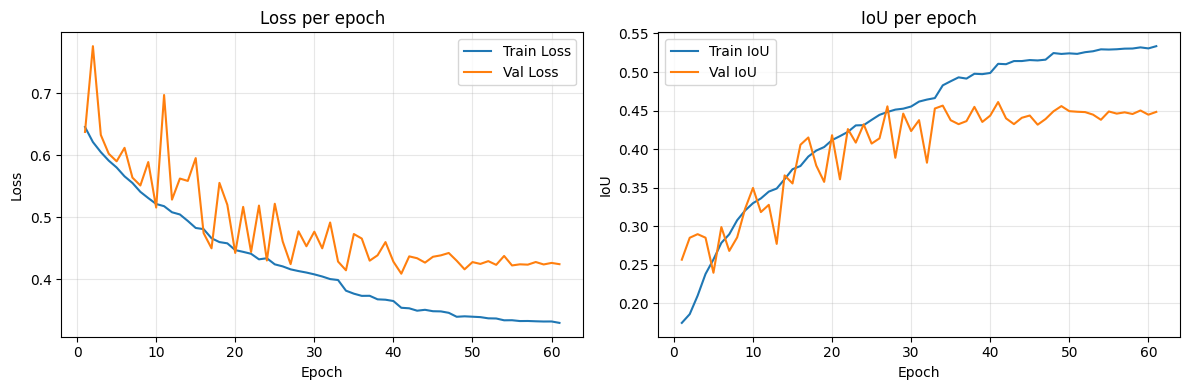

Saved curves → figures\training_curves.png


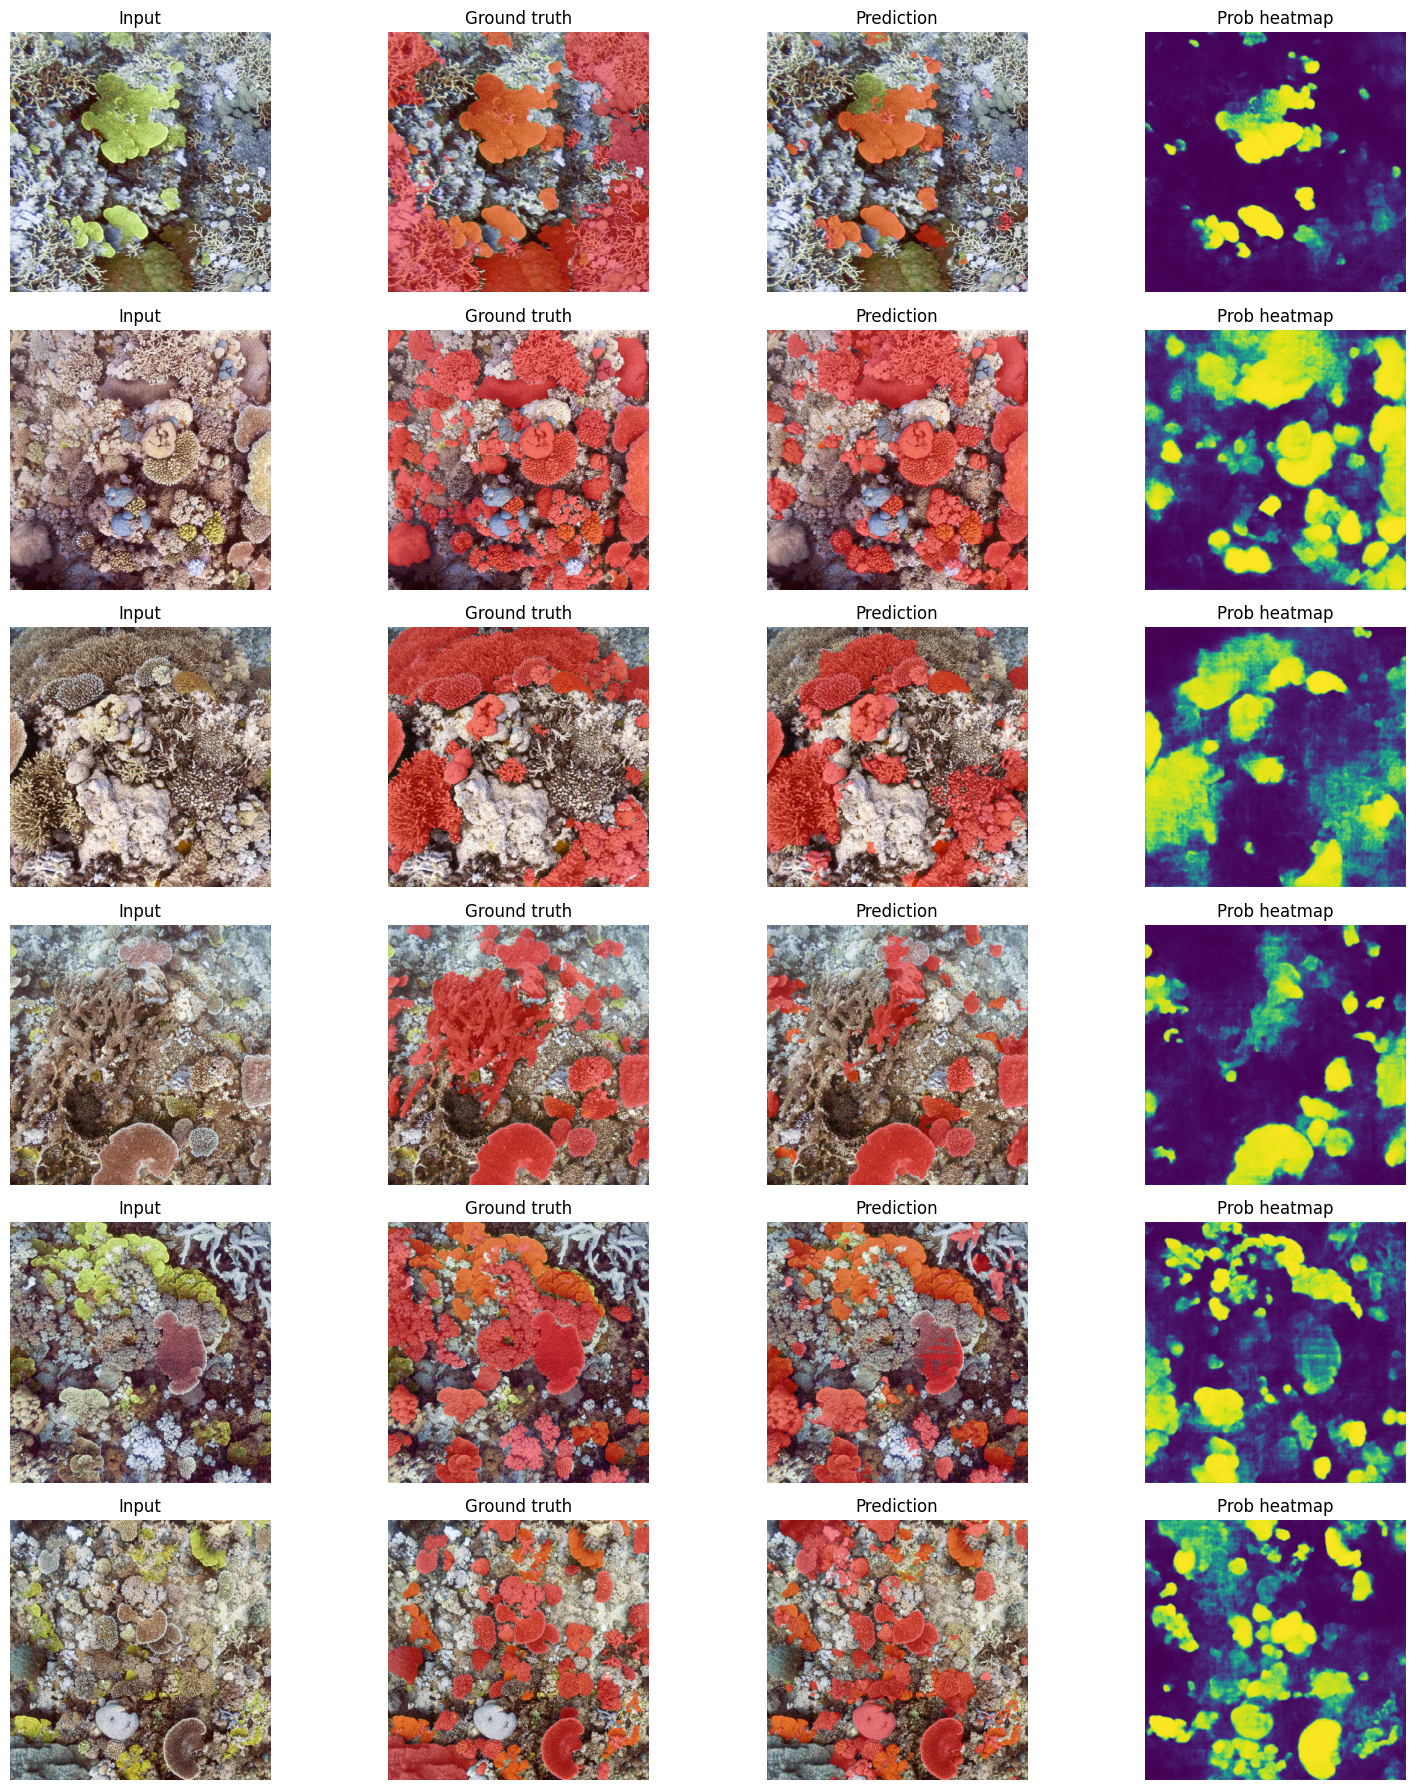

Saved val samples → figures\val_predictions.png


In [3]:
# ==== ONE-CELL TRAINING PIPELINE (CUDA + UNet + metrics + figures) ====
import os, json, time, math, random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import imageio.v2 as iio
import matplotlib.pyplot as plt

# -----------------------------
# Config (edit as needed)
# -----------------------------
MANIFEST_PATH = "all_coral_manifest_split.csv"   # <- point to your merged split CSV
TARGET_SIZE   = (512, 512)
BATCH_SIZE    = 8
EPOCHS        = 150
INIT_LR       = 3e-4
WEIGHT_DECAY  = 1e-4
ALPHA_LOSS    = 0.5        # BCE/Dice balance
PATIENCE      = 20         # early stopping (epochs)
VAL_THR       = 0.5        # initial binarization threshold
NUM_WORKERS   = 2
NUM_VIZ       = 6          # #validation samples to visualize
SEED          = 42

CKPT_DIR   = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True)
FIG_DIR    = Path("figures");     FIG_DIR.mkdir(exist_ok=True)
BEST_PATH  = CKPT_DIR/"unet_best.pt"
LAST_PATH  = CKPT_DIR/"unet_last.pt"
HIST_JSON  = CKPT_DIR/"train_history.json"
HIST_CSV   = CKPT_DIR/"train_history.csv"
BEST_THR_F = CKPT_DIR/"best_threshold.txt"
CURVES_PNG = FIG_DIR/"training_curves.png"
SAMPLES_PNG= FIG_DIR/"val_predictions.png"

# -----------------------------
# Reproducibility + CUDA check
# -----------------------------
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(SEED)

import torch.backends.cudnn as cudnn
cudnn.benchmark = True    # speed for fixed-size tensors
cudnn.deterministic = False

assert torch.cuda.is_available(), "CUDA not available. Please ensure a compatible GPU/driver/PyTorch install."
device = torch.device("cuda")
print("✅ Using device:", device)
print("GPU:", torch.cuda.get_device_name(0))
print("CUDA:", torch.version.cuda, "| PyTorch:", torch.__version__)

# -----------------------------
# Dataset & DataLoaders
# -----------------------------
class CoralSegDataset(Dataset):
    def __init__(self, manifest_csv, split, target_size=(512,512), augment=False):
        self.df = pd.read_csv(manifest_csv)
        self.df = self.df[self.df["split"]==split].reset_index(drop=True)
        self.target_size = target_size
        self.augment = augment

    def _nn_resize(self, arr, Ht, Wt):
        Hs, Ws = arr.shape[:2]
        if (Hs, Ws) == (Ht, Wt): return arr
        ys = (np.linspace(0, Hs-1, Ht)).round().astype(int)
        xs = (np.linspace(0, Ws-1, Wt)).round().astype(int)
        return arr[ys[:,None], xs[None,:]]

    def _augment_pair(self, I, M):
        if np.random.rand() < 0.5:
            I = np.flip(I, axis=1).copy(); M = np.flip(M, axis=1).copy()
        if np.random.rand() < 0.5:
            I = np.flip(I, axis=0).copy(); M = np.flip(M, axis=0).copy()
        k = np.random.choice([0,1,2,3])
        if k:
            I = np.rot90(I, k, axes=(0,1)).copy(); M = np.rot90(M, k, axes=(0,1)).copy()
        return I, M

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        I = iio.imread(r["image"])              # H,W,3 uint8
        M = iio.imread(r["mask_coral"]) > 0     # H,W bool

        Ht, Wt = self.target_size
        I = self._nn_resize(I, Ht, Wt)
        M = self._nn_resize(M.astype(np.uint8), Ht, Wt).astype(bool)

        if self.augment:
            I, M = self._augment_pair(I, M)

        I = torch.from_numpy(I).permute(2,0,1).float()/255.0
        M = torch.from_numpy(M.astype(np.float32)).unsqueeze(0)
        return I, M, r.get("source","?"), r.get("location","?"), r["image"]

# build loaders
train_ds = CoralSegDataset(MANIFEST_PATH, split="train", target_size=TARGET_SIZE, augment=True)
val_ds   = CoralSegDataset(MANIFEST_PATH, split="val",   target_size=TARGET_SIZE, augment=False)
test_ds  = CoralSegDataset(MANIFEST_PATH, split="test",  target_size=TARGET_SIZE, augment=False)

NUM_WORKERS=0
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0))
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0))

print(f"Datasets -> train:{len(train_ds)}  val:{len(val_ds)}  test:{len(test_ds)}")

# -----------------------------
# UNet model definition
# -----------------------------
def conv_block(cin, cout):
    return nn.Sequential(
        nn.Conv2d(cin, cout, 3, padding=1, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
        nn.Conv2d(cout, cout, 3, padding=1, bias=False),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base=32):
        super().__init__()
        self.enc1 = conv_block(in_ch, base)
        self.enc2 = conv_block(base, base*2)
        self.enc3 = conv_block(base*2, base*4)
        self.enc4 = conv_block(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(base*8, base*16)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = conv_block(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = conv_block(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = conv_block(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = conv_block(base*2, base)
        self.head = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        d4 = self.up4(b); d4 = torch.cat([d4, e4], dim=1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], dim=1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], dim=1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], dim=1); d1 = self.dec1(d1)
        return self.head(d1)  # logits

# -----------------------------
# Losses, metrics, optimizer
# -----------------------------
bce = nn.BCEWithLogitsLoss()
def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2*(probs*targets).sum(dim=(1,2,3))
    den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps
    return 1 - (num/den).mean()

def combo_loss(logits, targets, alpha=ALPHA_LOSS):
    return alpha*bce(logits, targets) + (1-alpha)*dice_loss(logits, targets)

@torch.no_grad()
def iou_from_logits(logits, targets, thr=VAL_THR, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs >= thr).float()
    inter = (preds*targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
    return ((inter+eps)/(union+eps)).mean().item()

model = UNet(in_ch=3, out_ch=1, base=32).to(device)
optimizer = optim.AdamW(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5)
scaler = torch.amp.GradScaler()

# -----------------------------
# Training / validation
# -----------------------------
history = {"epoch": [], "train_loss": [], "train_iou": [], "val_loss": [], "val_iou": [], "lr": []}
best_iou, best_epoch, wait = 0.0, 0, 0
t0 = time.time()

import time

# --- quiet run_epoch: no per-batch prints, returns epoch averages ---
def run_epoch(loader, train=True, thr=VAL_THR):
    if train: model.train()
    else:     model.eval()

    total_loss = 0.0
    total_iou  = 0.0
    n_batches  = 0

    for (imgs, masks, *_rest) in loader:
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            with torch.amp.autocast(device_type="cuda"):
                logits = model(imgs)
                loss   = combo_loss(logits, masks)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            iou = iou_from_logits(logits, masks, thr=thr)

        total_loss += float(loss.item())
        total_iou  += float(iou)
        n_batches  += 1

    return total_loss / max(1, n_batches), total_iou / max(1, n_batches)



# --- per-epoch loop: single concise line with both train & val metrics ---
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_iou = run_epoch(train_loader, train=True,  thr=VAL_THR)
    va_loss, va_iou = run_epoch(val_loader,   train=False, thr=VAL_THR)

    # LR scheduling (and manual "verbose")
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(va_iou)
    lr_now = optimizer.param_groups[0]["lr"]
    if lr_now < prev_lr:
        print(f"  ⤵ LR reduced: {prev_lr:.1e} → {lr_now:.1e}")

    # log & save history
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_iou"].append(tr_iou)
    history["val_loss"].append(va_loss)
    history["val_iou"].append(va_iou)
    history["lr"].append(lr_now)

    # single per-epoch summary line
    print(f"Epoch {epoch:03d} | "
          f"Train Loss {tr_loss:.4f}  IoU {tr_iou:.4f}  ||  "
          f"Val Loss {va_loss:.4f}  IoU {va_iou:.4f}  | LR {lr_now:.1e}")

    # save last
    torch.save({"model": model.state_dict(),
                "epoch": epoch, "val_iou": va_iou, "thr": VAL_THR}, LAST_PATH)

    # save best
    if va_iou > best_iou:
        best_iou, best_epoch, wait = va_iou, epoch, 0
        torch.save({"model": model.state_dict(),
                    "epoch": epoch, "val_iou": va_iou, "thr": VAL_THR}, BEST_PATH)
        print(f"  ✅ New best IoU {best_iou:.4f} @ epoch {best_epoch} → {BEST_PATH}")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break


# persist history for later reuse
with open(HIST_JSON, "w") as f: json.dump(history, f)
pd.DataFrame(history).to_csv(HIST_CSV, index=False)

print(f"\nBest Val IoU {best_iou:.4f} at epoch {best_epoch}. "
      f"Training time: {(time.time()-t0)/60:.1f} min.")
print(f"Artifacts → {BEST_PATH}, {LAST_PATH}, {HIST_JSON}, {HIST_CSV}")

# -----------------------------
# Threshold sweep on validation
# -----------------------------
@torch.no_grad()
def val_iou_at_thr(loader, model, thr):
    model.eval()
    tot, n = 0.0, 0
    for imgs, masks, *_ in loader:
        imgs = imgs.to(device); masks = masks.to(device)
        logits = model(imgs)
        tot += iou_from_logits(logits, masks, thr=thr); n += 1
    return tot/max(1,n)

# reload best before sweep
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

ths = np.linspace(0.1, 0.9, 17)
scores = [(float(t), val_iou_at_thr(val_loader, model, float(t))) for t in ths]
best_thr, best_val = max(scores, key=lambda x: x[1])
with open(BEST_THR_F, "w") as f: f.write(str(best_thr))
print("Threshold sweep:", scores)
print(f"Best threshold on val: {best_thr:.2f} (IoU {best_val:.4f})  -> saved to {BEST_THR_F}")

# -----------------------------
# Plots: training curves
# -----------------------------
epochs = history["epoch"]
tr_loss = history["train_loss"]; va_loss = history["val_loss"]
tr_iou  = history["train_iou"];  va_iou  = history["val_iou"]

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(epochs, tr_loss, label="Train Loss")
axes[0].plot(epochs, va_loss, label="Val Loss")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss per epoch"); axes[0].grid(True, alpha=0.3); axes[0].legend()

axes[1].plot(epochs, tr_iou, label="Train IoU")
axes[1].plot(epochs, va_iou, label="Val IoU")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU per epoch"); axes[1].grid(True, alpha=0.3); axes[1].legend()

plt.tight_layout(); plt.savefig(CURVES_PNG, dpi=140); plt.show()
print(f"Saved curves → {CURVES_PNG}")

# -----------------------------
# Viz: Pred vs GT on val set
# -----------------------------
def overlay(img_uint8, mask_bool, alpha=0.45):
    v = img_uint8.astype(np.float32)
    if v.ndim == 2: v = np.repeat(v[...,None], 3, axis=2)
    r,g,b = v[...,0], v[...,1], v[...,2]
    r = np.where(mask_bool, 255*alpha + r*(1-alpha), r)
    g = np.where(mask_bool, g*(1-alpha), g)
    b = np.where(mask_bool, b*(1-alpha), b)
    return np.stack([r,g,b], axis=-1).clip(0,255).astype(np.uint8)

def to_uint8_image(t):
    a = (t.detach().cpu().numpy().transpose(1,2,0) * 255.0).clip(0,255).astype(np.uint8)
    return a

picked = []
with torch.no_grad():
    for batch in val_loader:
        imgs, masks = batch[0].to(device), batch[1].to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)[:,0].cpu().numpy()  # BxHxW
        preds = (probs >= best_thr)
        for i in range(imgs.size(0)):
            img_u8 = to_uint8_image(imgs[i].cpu())
            gt     = masks[i,0].cpu().numpy().astype(bool)
            pr     = preds[i].astype(bool)
            pb     = probs[i]
            picked.append((img_u8, gt, pr, pb))
            if len(picked) >= NUM_VIZ: break
        if len(picked) >= NUM_VIZ: break

cols, rows = 4, len(picked)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
if rows == 1: axes = np.array([axes])

for r, (img_u8, gt, pr, pb) in enumerate(picked):
    axes[r,0].imshow(img_u8);                  axes[r,0].set_title("Input"); axes[r,0].axis("off")
    axes[r,1].imshow(overlay(img_u8, gt));     axes[r,1].set_title("Ground truth"); axes[r,1].axis("off")
    axes[r,2].imshow(overlay(img_u8, pr));     axes[r,2].set_title("Prediction");   axes[r,2].axis("off")
    im = axes[r,3].imshow(pb, vmin=0, vmax=1); axes[r,3].set_title("Prob heatmap"); axes[r,3].axis("off")

plt.tight_layout(); plt.savefig(SAMPLES_PNG, dpi=140); plt.show()
print(f"Saved val samples → {SAMPLES_PNG}")


In [5]:
for k in range(min(5, len(train_ds))):
    I, M, *_ = train_ds[k]
    print(k, I.shape, M.shape)


0 torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
1 torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
2 torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
3 torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
4 torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
